Data head:
  Iso3_code     Country  Region       Subregion         Indicator  \
0       AZE  Azerbaijan    Asia    Western Asia  Violent offences   
1       BEL     Belgium  Europe  Western Europe  Violent offences   
2       BGR    Bulgaria  Europe  Eastern Europe  Violent offences   
3       BHR     Bahrain    Asia    Western Asia  Violent offences   
4       BLR     Belarus  Europe  Eastern Europe  Violent offences   

            Dimension         Category    Sex    Age  Year  \
0  by type of offence  Serious assault  Total  Total  2003   
1  by type of offence  Serious assault  Total  Total  2003   
2  by type of offence  Serious assault  Total  Total  2003   
3  by type of offence  Serious assault  Total  Total  2003   
4  by type of offence  Serious assault  Total  Total  2003   

  Unit of measurement  Crime_Count Source  
0              Counts        155.0    CTS  
1              Counts      61959.0    CTS  
2              Counts       3806.0    CTS  
3              Counts    

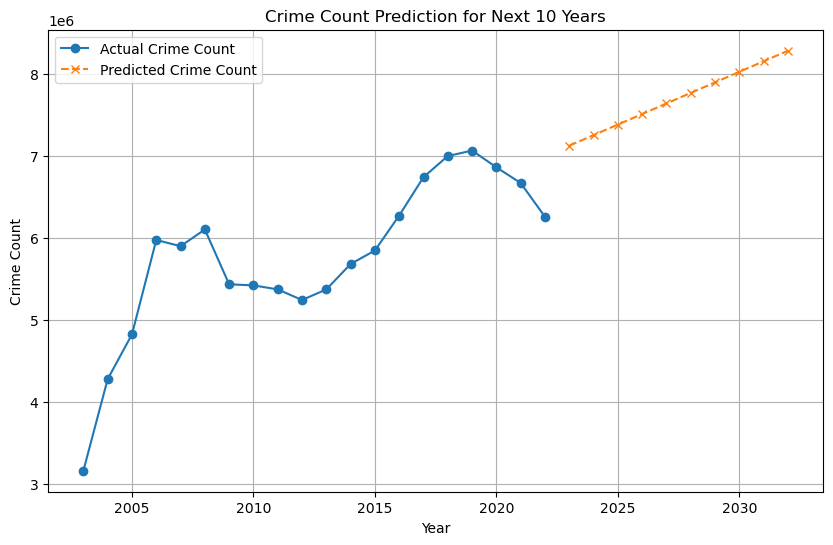

Predicted crime count for next 10 years:
   Year  Predicted_Crime_Count
0  2023           7.128102e+06
1  2024           7.257011e+06
2  2025           7.385921e+06
3  2026           7.514831e+06
4  2027           7.643741e+06
5  2028           7.772651e+06
6  2029           7.901561e+06
7  2030           8.030471e+06
8  2031           8.159381e+06
9  2032           8.288291e+06


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load data
file_path = 'data_cts_violent_and_sexual_crime.xlsx'
df = pd.read_excel(file_path, sheet_name='data_cts_violent_and_sexual_cri')

# Preview data
print('Data head:')
print(df.head())

# Convert Year to numeric if needed
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Convert Crime_Count to numeric
df['Crime_Count'] = pd.to_numeric(df['Crime_Count'], errors='coerce')

# Drop rows with missing Year or Crime_Count
df = df.dropna(subset=['Year', 'Crime_Count'])

# Aggregate the data by Year for overall crime trend
crime_by_year = df.groupby('Year')['Crime_Count'].sum().reset_index()
crime_by_year = crime_by_year.sort_values('Year')

print('Aggregated crime data by year:')
print(crime_by_year.head())

# Prepare training data
X = crime_by_year[['Year']].values
y = crime_by_year['Crime_Count'].values

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict next 10 years (extrapolate from the maximum year from data)
max_year = int(crime_by_year['Year'].max())
future_years = np.arange(max_year+1, max_year+11).reshape(-1,1)
predictions = model.predict(future_years)

# Visualize actual data and predictions
plt.figure(figsize=(10,6))
plt.plot(crime_by_year['Year'], crime_by_year['Crime_Count'], label='Actual Crime Count', marker='o')
plt.plot(future_years.flatten(), predictions, label='Predicted Crime Count', marker='x', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Crime Count Prediction for Next 10 Years')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, print predictions
pred_df = pd.DataFrame({'Year': future_years.flatten(), 'Predicted_Crime_Count': predictions})
print('Predicted crime count for next 10 years:')
print(pred_df)

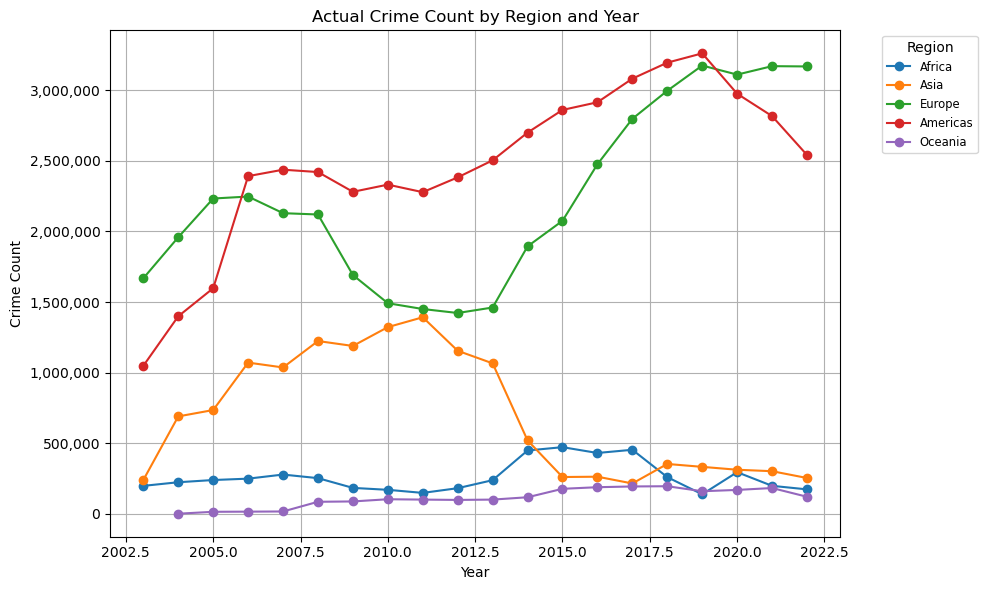

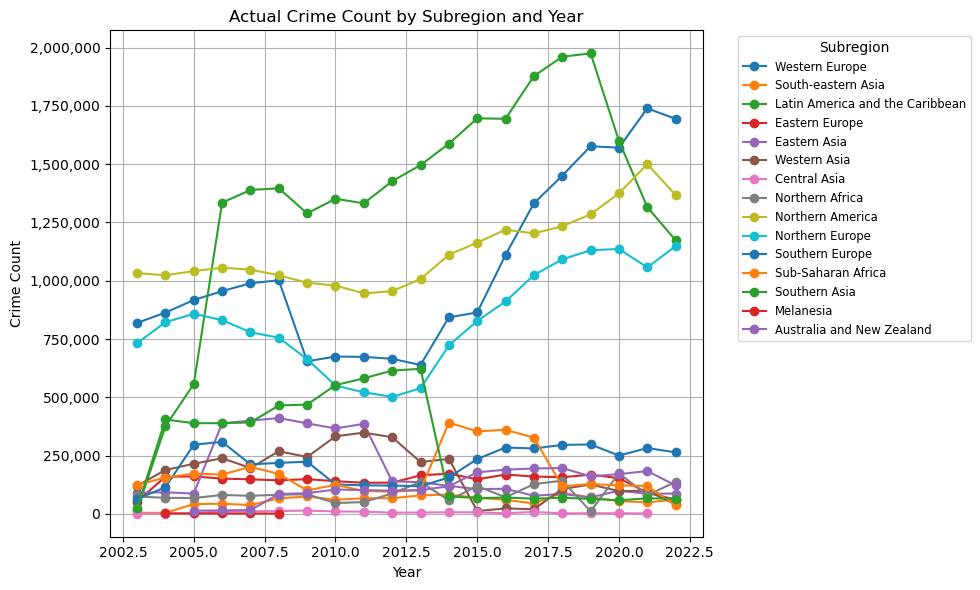

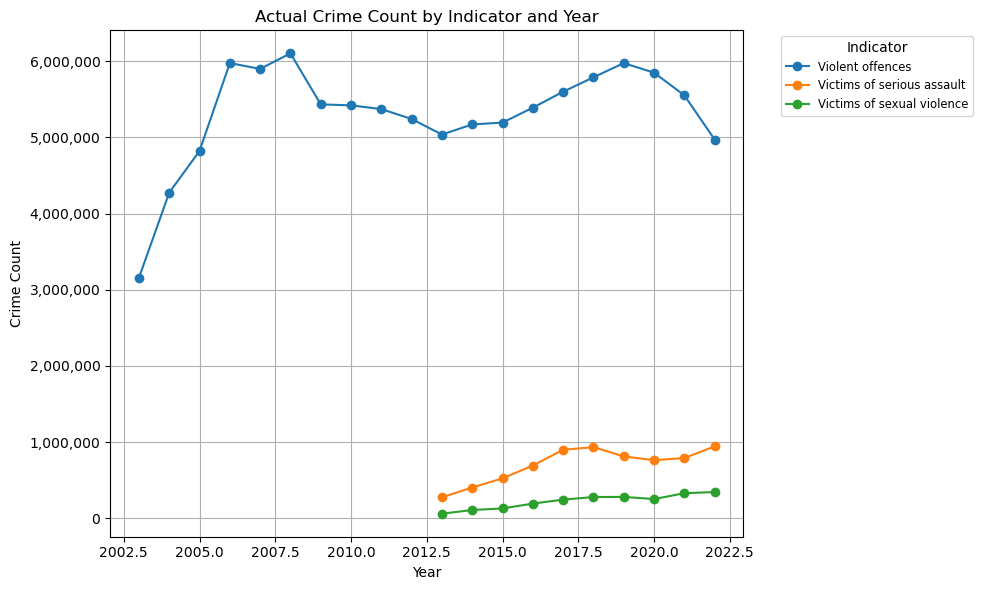

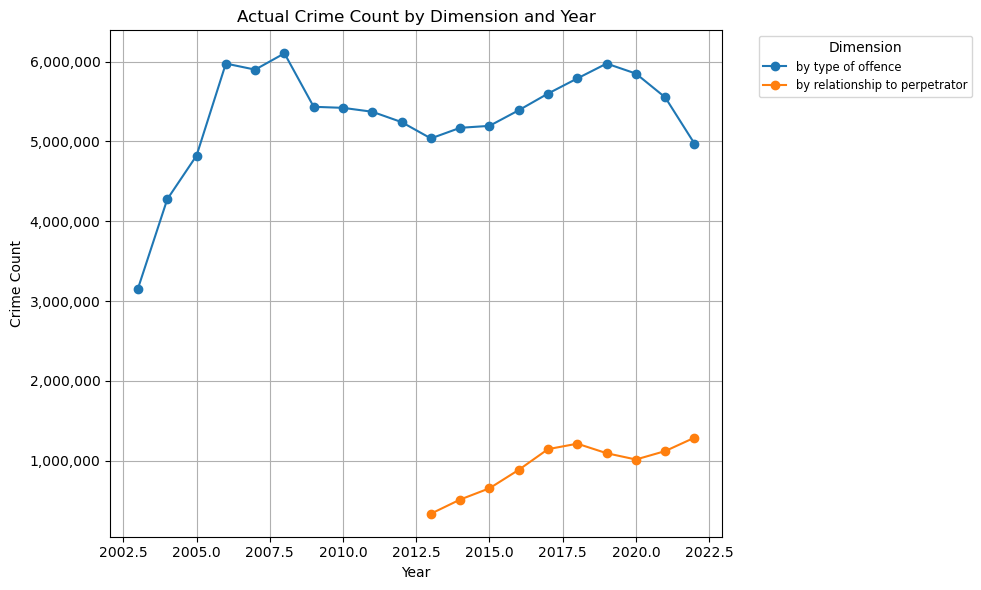

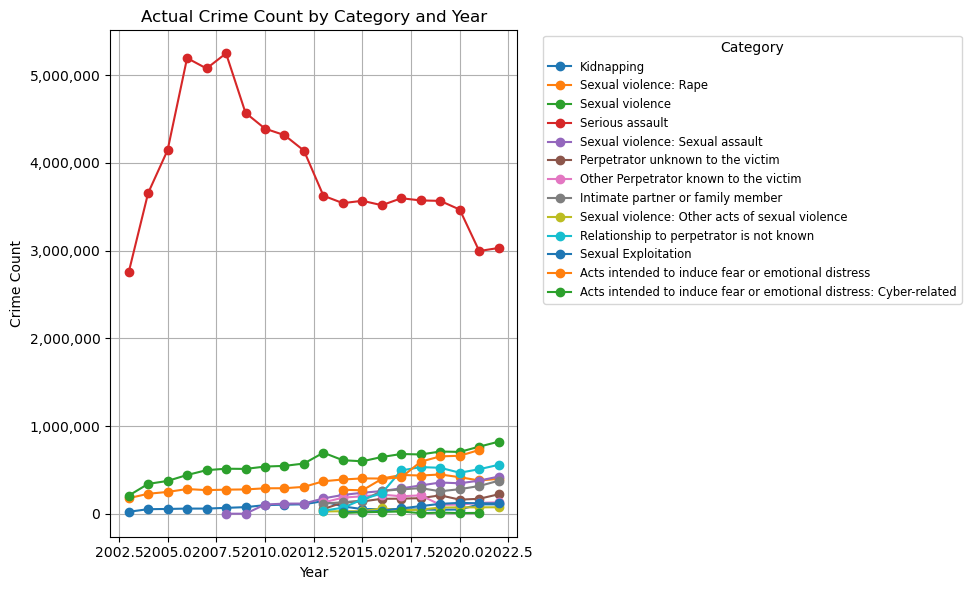

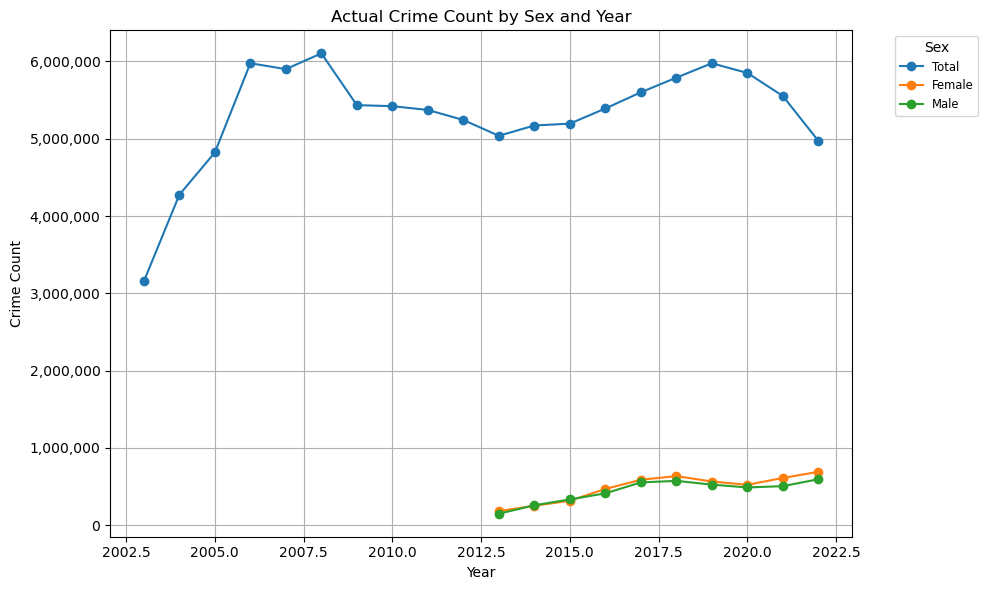

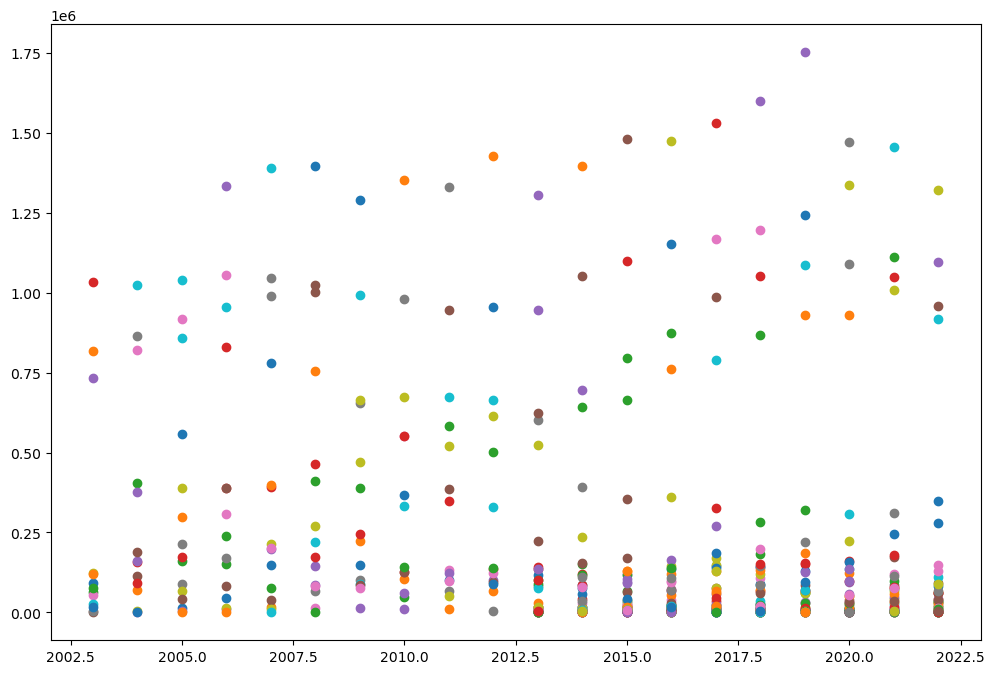

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import StrMethodFormatter

# Load data from Excel
file_path = 'data_cts_violent_and_sexual_crime.xlsx'
df = pd.read_excel(file_path, sheet_name='data_cts_violent_and_sexual_cri')

# Preprocess: convert Year and Crime_Count to numeric and drop missing values
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Crime_Count'] = pd.to_numeric(df['Crime_Count'], errors='coerce')
df = df.dropna(subset=['Year', 'Crime_Count'])

# -------------------------------
# First: Plot actual crime counts by individual grouping: Region, Subregion, Indicator, Dimension, Category, Sex (including Year)
grouping_vars = {
    'Region': ['Region','Year'],
    'Subregion': ['Subregion','Year'],
    'Indicator': ['Indicator','Year'],
    'Dimension': ['Dimension','Year'],
    'Category': ['Category','Year'],
    'Sex': ['Sex','Year']
}

for key, group in grouping_vars.items():
    agg = df.groupby(group)['Crime_Count'].sum().reset_index().sort_values('Year')
    plt.figure(figsize=(10,6))
    unique_vals = agg[key].unique()
    for val in unique_vals:
        sub = agg[agg[key]==val]
        plt.plot(sub['Year'], sub['Crime_Count'], marker='o', label=f"{val}")
    plt.xlabel('Year')
    plt.ylabel('Crime Count')
    plt.title(f'Actual Crime Count by {key} and Year')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.legend(title=key, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Second: Plot combined actual and predicted curves for disaggregation by Region, Subregion, Indicator, Dimension, Sex, Year.
# Note that predictions will be calculated separately per subgroup.

# We'll group using these columns:
group_cols = ['Region','Subregion','Indicator','Dimension','Sex','Year']

# Aggregate the data
agg_group = df.groupby(group_cols)['Crime_Count'].sum().reset_index()
agg_group = agg_group.sort_values('Year')

# Get the unique combination of grouping variables (excluding Year)
unique_groups = agg_group.drop('Year', axis=1).drop_duplicates()

plt.figure(figsize=(12,8))

# For each subgroup, fit a linear regression if there is enough data and plot both actual and predictions.
for _, subgroup in unique_groups.iterrows():
    # Build a mask to filter the data based on the subgroup values
    mask = np.ones(len(agg_group), dtype=bool)
    for col in subgroup.index:
        mask = mask & (agg_group[col] == subgroup[col])
    subdata = agg_group[mask]
    subdata = subdata.sort_values('Year')
    
    # Plot actual data
    label_actual = ', '.join([f"{col}: {subgroup[col]}" for col in subgroup.index])
    plt.plot(subdata['Year'], subdata['Crime_Count'], marker='o', label=f"Actual ({label_actual})")
    
    # Only make predictions if there are at least 2 time points
    if subdata['Year'].nunique() >= 2:
        X = subdata[['Year']].values
        y = subdata['Crime_Count'].values
        model = LinearRegression()
        model.fit(X, y)
        max_year = int(subdata['Year'].max())
        future_years = np.arange(max_year+1, max_year+11).reshape(-1, 1)
        pred = model.predict(future_years)
        plt.plot(future_years.flatten(), pred, marker='x', linestyle='--', label=f"Predicted ({label_actual})")


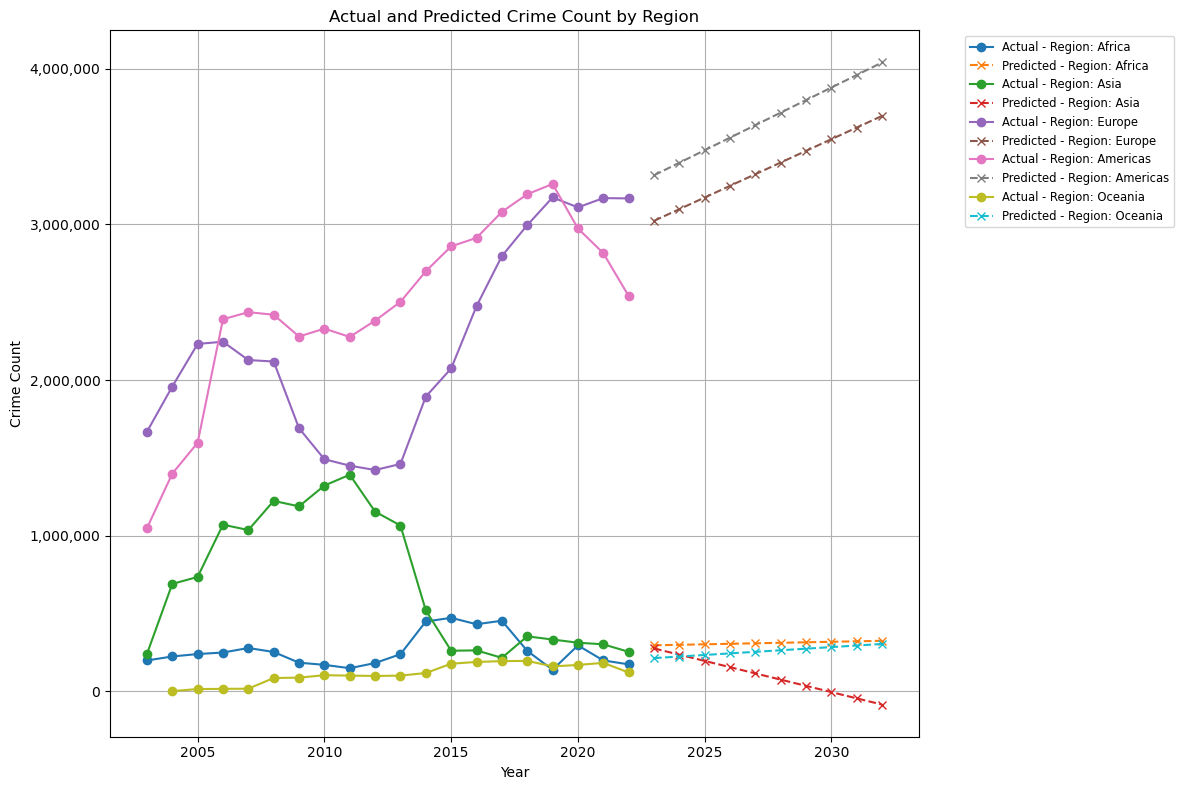

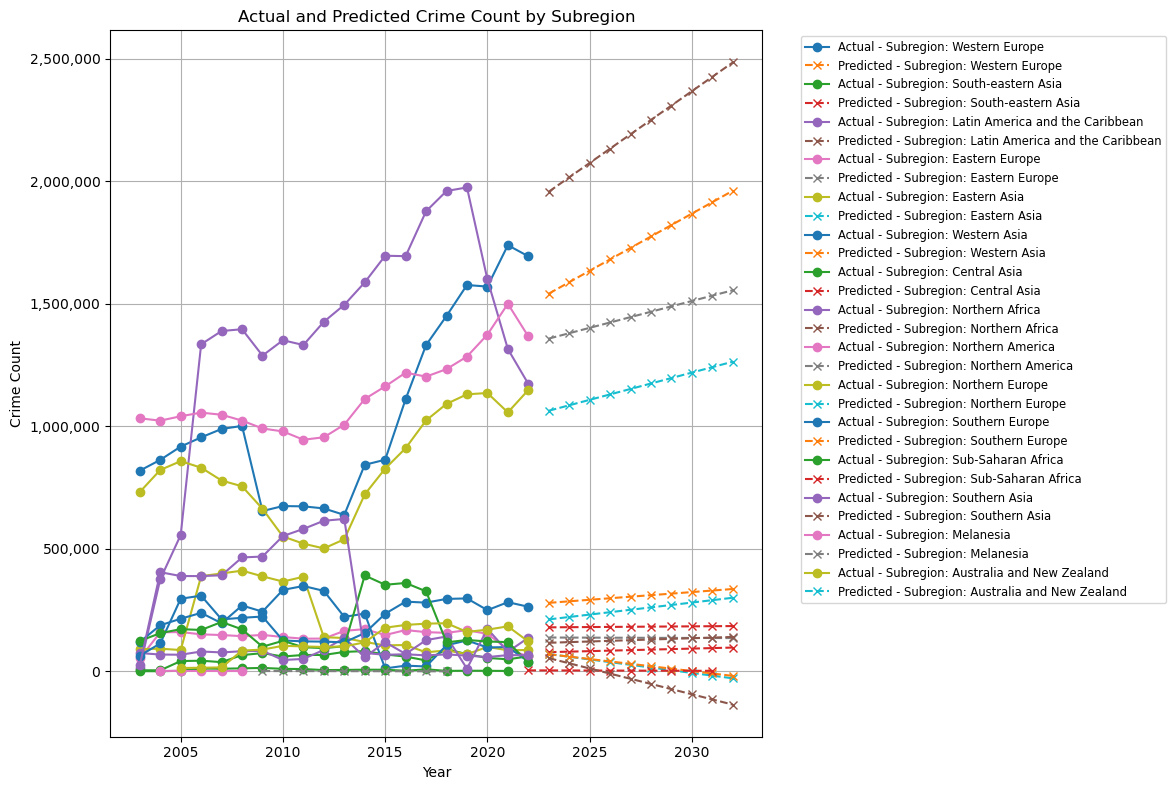

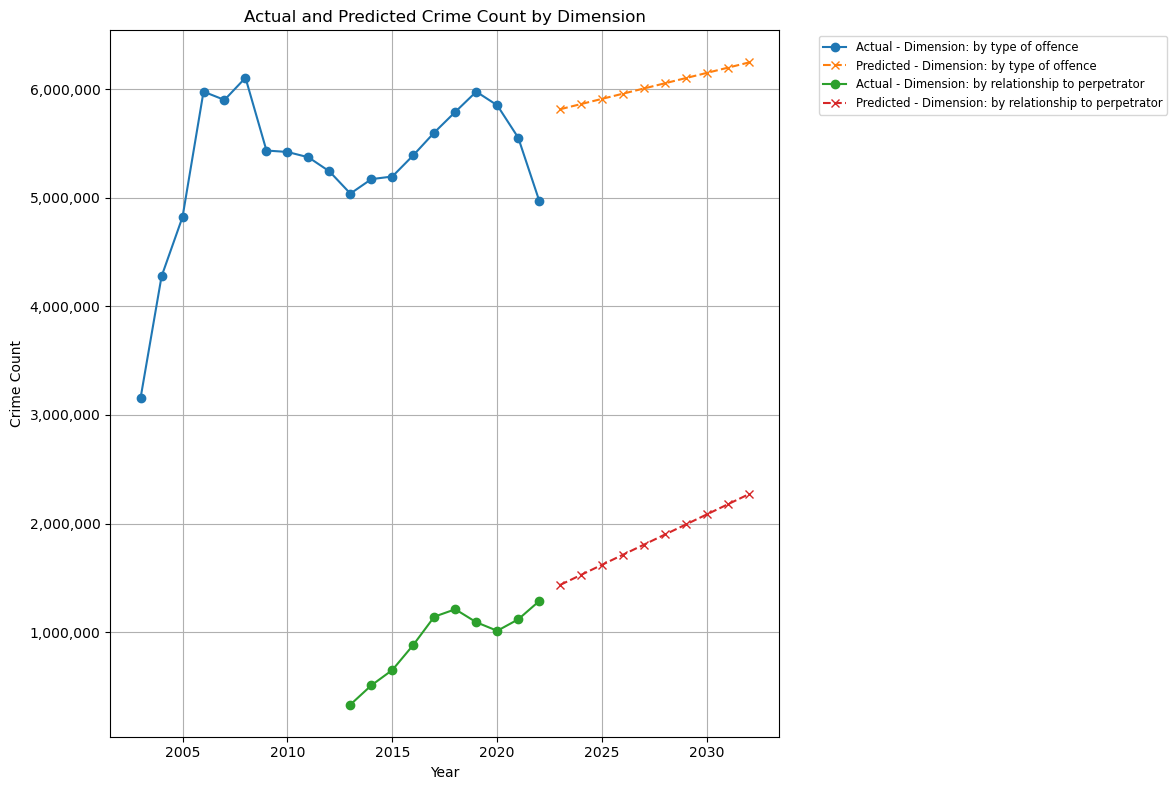

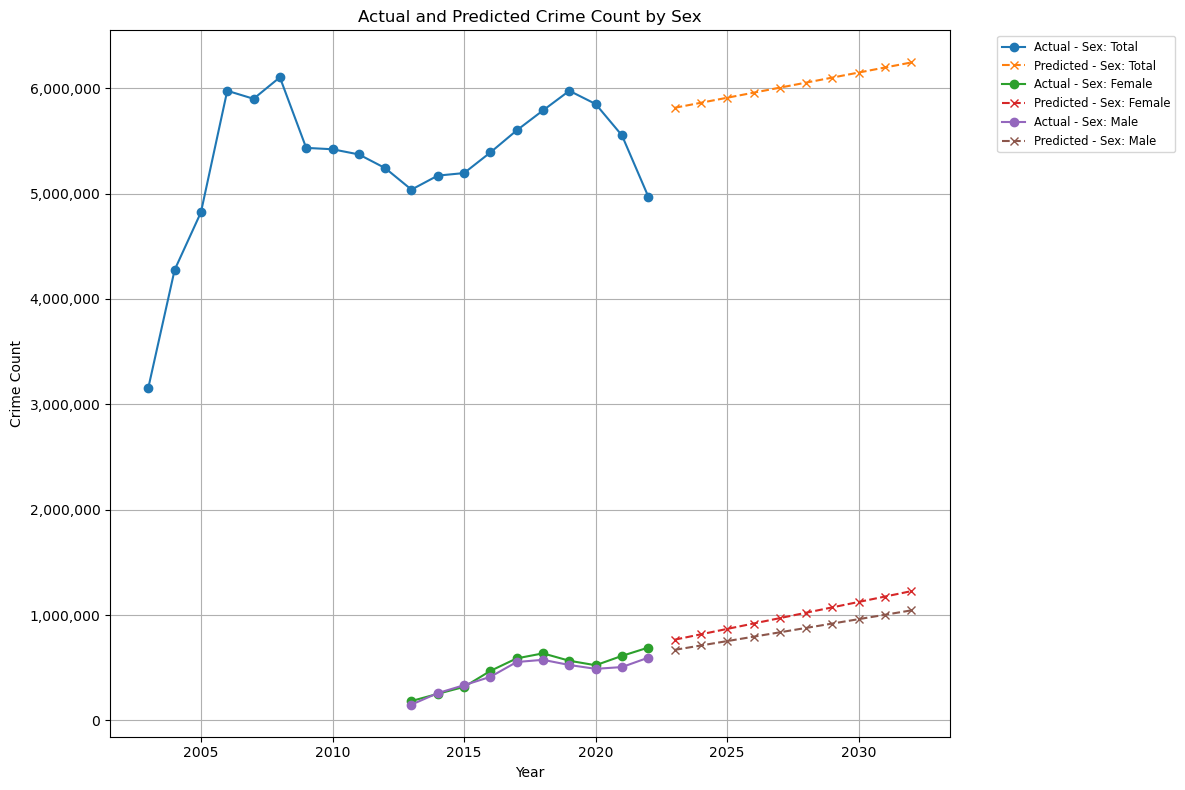

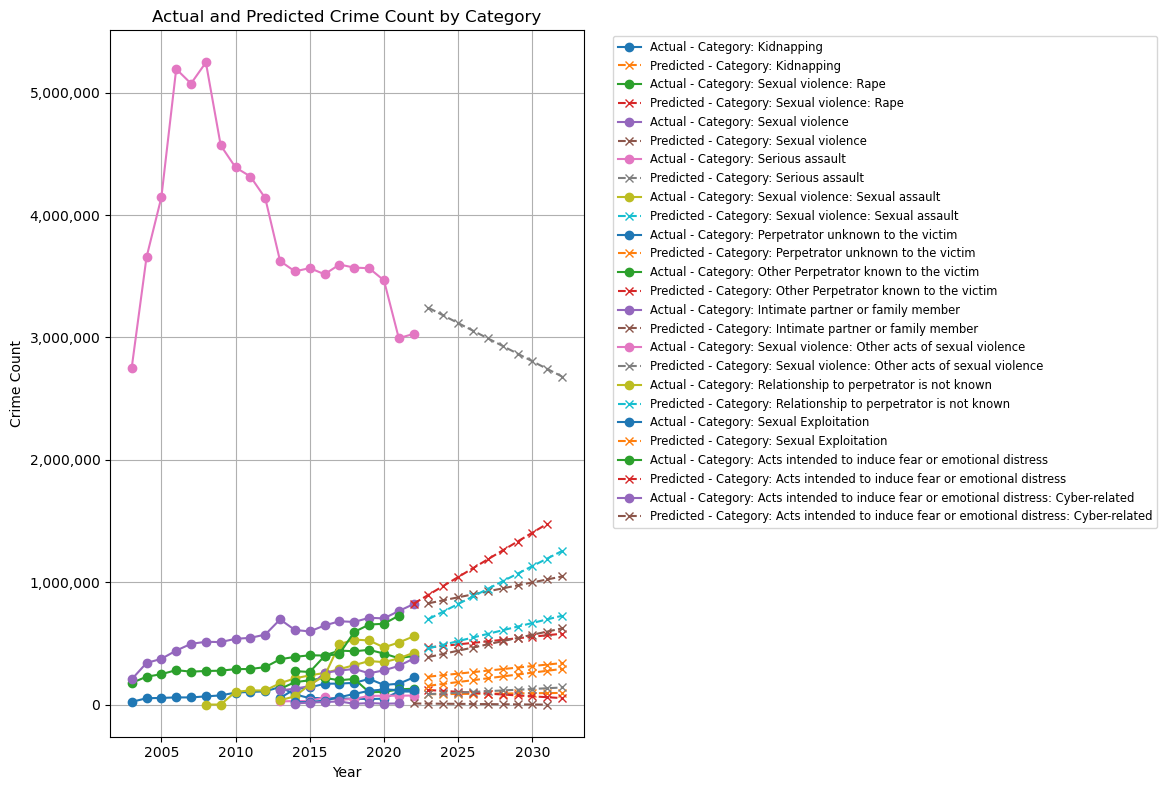

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import StrMethodFormatter

# Load and preprocess data
file_path = 'data_cts_violent_and_sexual_crime.xlsx'
df = pd.read_excel(file_path, sheet_name='data_cts_violent_and_sexual_cri')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Crime_Count'] = pd.to_numeric(df['Crime_Count'], errors='coerce')
df = df.dropna(subset=['Year', 'Crime_Count'])

def plot_actual_vs_predicted(group_var):
    """
    For the grouping variable in group_var (string), group the data by that variable and Year,
    then plot actual daily crime counts and 10-year predictions for each subgroup in a single graph.
    """
    # Aggregate data
    agg = df.groupby([group_var, 'Year'])['Crime_Count'].sum().reset_index()
    agg = agg.sort_values('Year')
    
    plt.figure(figsize=(12,8))
    unique_vals = agg[group_var].unique()
    
    for val in unique_vals:
        subdata = agg[agg[group_var]==val].sort_values('Year')
        
        # Plot actual trend
        plt.plot(subdata['Year'], subdata['Crime_Count'], marker='o', label=f"Actual - {group_var}: {val}")
        
        # Only predict if we have at least 2 distinct years
        if subdata['Year'].nunique() >= 2:
            X = subdata[['Year']].values
            y = subdata['Crime_Count'].values
            model = LinearRegression()
            model.fit(X, y)
            max_year = int(subdata['Year'].max())
            future_years = np.arange(max_year+1, max_year+11).reshape(-1,1)
            pred = model.predict(future_years)
            # Plot predicted trend
            plt.plot(future_years.flatten(), pred, marker='x', linestyle='--', 
                     label=f"Predicted - {group_var}: {val}")
    
    plt.xlabel('Year')
    plt.ylabel('Crime Count')
    plt.title(f'Actual and Predicted Crime Count by {group_var}')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate separate graphs for each variable
group_vars = ['Region', 'Subregion', 'Dimension', 'Sex', 'Category']
for var in group_vars:
    plot_actual_vs_predicted(var)

In [4]:
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import StrMethodFormatter
from matplotlib.backends.backend_pdf import PdfPages

# Load and preprocess data
file_path = 'data_cts_violent_and_sexual_crime.xlsx'
df = pd.read_excel(file_path, sheet_name='data_cts_violent_and_sexual_cri')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Crime_Count'] = pd.to_numeric(df['Crime_Count'], errors='coerce')
df = df.dropna(subset=['Year', 'Crime_Count'])

def plot_actual_vs_predicted(ax, group_var):
    """
    Plots actual crime counts and 10-year linear regression predictions for subgroups defined by group_var.
    """
    # Aggregate data
    agg = df.groupby([group_var, 'Year'])['Crime_Count'].sum().reset_index()
    agg = agg.sort_values('Year')
    unique_vals = agg[group_var].unique()
    
    for val in unique_vals:
        subdata = agg[agg[group_var] == val].sort_values('Year')
        # Plot actual trend
        ax.plot(subdata['Year'], subdata['Crime_Count'], marker='o', label=f"Actual - {val}")
        # Predict only if at least 2 data points exist
        if subdata['Year'].nunique() >= 2:
            X = subdata[['Year']].values
            y = subdata['Crime_Count'].values
            model = LinearRegression()
            model.fit(X, y)
            max_year = int(subdata['Year'].max())
            future_years = np.arange(max_year + 1, max_year + 11).reshape(-1, 1)
            pred = model.predict(future_years)
            # Plot predicted trend
            ax.plot(future_years.flatten(), pred, marker='x', linestyle='--', label=f"Predicted - {val}")
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Crime Count')
    ax.set_title(f'Actual and Predicted Crime Count by {group_var}')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Specify the grouping variables for which separate graphs will be generated
group_vars = ['Region', 'Subregion', 'Dimension', 'Sex', 'Category']
pdf_filename = 'crime_prediction_report.pdf'

# Create a PDF file with all the figures
with PdfPages(pdf_filename) as pdf:
    for var in group_vars:
        fig, ax = plt.subplots(figsize=(12,8))
        plot_actual_vs_predicted(ax, var)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"PDF report has been saved as {pdf_filename}")

PDF report has been saved as crime_prediction_report.pdf
